In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
cd drive/MyDrive/


/content/drive/MyDrive


In [2]:
cd MLND-Capstone-master

/content/drive/MyDrive/MLND-Capstone-master


In [3]:
%matplotlib inline

from matplotlib import pyplot as plt
import numpy as np
import pickle
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# Import necessary items from Keras
from keras.models import Sequential
from keras.layers import Activation, Dropout, UpSampling2D
from keras.layers import Conv2DTranspose, Conv2D, MaxPooling2D,Flatten,Dense
from keras.layers import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
import tensorflow as tf



In [11]:
def create_model(input_shape, pool_size):
    # Create the actual neural network here
    model = Sequential()
    # Normalizes incoming inputs. First layer needs the input shape to work
    model.add(BatchNormalization(input_shape=input_shape))

    # Below layers were re-named for easier reading of model summary; this not necessary
    # Conv Layer 1
    model.add(Conv2D(8, (3, 3), padding='valid', strides=(1,1), activation = 'sigmoid', name = 'Conv1'))

    # Conv Layer 2
    model.add(Conv2D(16, (3, 3), padding='valid', strides=(1,1), activation = 'sigmoid', name = 'Conv2'))

    # Pooling 1
    model.add(MaxPooling2D(pool_size=pool_size))

    # Conv Layer 3
    model.add(Conv2D(16, (3, 3), padding='valid', strides=(1,1), activation = 'sigmoid', name = 'Conv3'))
    model.add(Dropout(0.2))

    # Conv Layer 4
    model.add(Conv2D(32, (3, 3), padding='valid', strides=(1,1), activation = 'sigmoid', name = 'Conv4'))
    model.add(Dropout(0.2))

    # Conv Layer 5
    model.add(Conv2D(32, (3, 3), padding='valid', strides=(1,1), activation = 'sigmoid', name = 'Conv5'))
    model.add(Dropout(0.2))

    # Pooling 2
    model.add(MaxPooling2D(pool_size=pool_size))

    # Conv Layer 6
    model.add(Conv2D(64, (3, 3), padding='valid', strides=(1,1), activation = 'sigmoid', name = 'Conv6'))
    model.add(Dropout(0.2))

    # Conv Layer 7
    model.add(Conv2D(64, (3, 3), padding='valid', strides=(1,1), activation = 'sigmoid', name = 'Conv7'))
    model.add(Dropout(0.2))

    # Pooling 3
    model.add(MaxPooling2D(pool_size=pool_size))

    # Upsample 1
    model.add(UpSampling2D(size=pool_size))

    # Deconv 1
    model.add(Conv2DTranspose(64, (3, 3), padding='valid', strides=(1,1), activation = 'sigmoid', name = 'Deconv1'))
    model.add(Dropout(0.2))

    # Deconv 2
    model.add(Conv2DTranspose(64, (3, 3), padding='valid', strides=(1,1), activation = 'sigmoid', name = 'Deconv2'))
    model.add(Dropout(0.2))

    # Upsample 2
    model.add(UpSampling2D(size=pool_size))

    # Deconv 3
    model.add(Conv2DTranspose(32, (3, 3), padding='valid', strides=(1,1), activation = 'sigmoid', name = 'Deconv3'))
    model.add(Dropout(0.2))

    # Deconv 4
    model.add(Conv2DTranspose(32, (3, 3), padding='valid', strides=(1,1), activation = 'sigmoid', name = 'Deconv4'))
    model.add(Dropout(0.2))

    # Deconv 5
    model.add(Conv2DTranspose(16, (3, 3), padding='valid', strides=(1,1), activation = 'sigmoid', name = 'Deconv5'))
    model.add(Dropout(0.2))

    # Upsample 3
    model.add(UpSampling2D(size=pool_size))

    # Deconv 6
    model.add(Conv2DTranspose(16, (3, 3), padding='valid', strides=(1,1), activation = 'sigmoid', name = 'Deconv6'))

    # Final layer - only including one channel so 1 filter
    model.add(Conv2DTranspose(1, (3, 3), padding='valid', strides=(1,1), activation = 'sigmoid', name = 'Final'))

    return model

In [12]:
def accuracy_plot(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

In [13]:
def loss_plot(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()


In [14]:
def train_model():
    # Load training images
    train_images = pickle.load(open("/content/drive/MyDrive/MLND-Capstone-master/full_CNN_train.p", "rb" ))

    # Load image labels
    labels = pickle.load(open("/content/drive/MyDrive/MLND-Capstone-master/full_CNN_labels.p", "rb" ))
    
    train_images = np.array(train_images)
    labels = np.array(labels)

    # Normalize labels - training images get normalized to start in the network
    labels = labels / 255
    #Splitting into train,validation and test dataset
    train_images, labels = shuffle(train_images, labels)
    X_train, X_val, y_train, y_val = train_test_split(train_images, labels, test_size=0.1)
    X_train, X_test, y_train, y_test= train_test_split(X_train, y_train, test_size=0.05)
    print("Total Number of images: ",len(X_train)+len(X_val)+len(X_test))
    print("Number of training images: ",len(X_train))
    print("Number of Validation images: ",len(X_val))
    print("Number of test images: ",len(X_test))

    # Batch size, epochs and pool size below are all paramaters
    batch_size = 128
    epochs = 10
    pool_size = (2, 2)
    input_shape = X_train.shape[1:]

    # Create the neural network
    model = create_model(input_shape, pool_size)
    print(model)
    # Using a generator to help the model use less data but is not used 
    datagen = ImageDataGenerator(channel_shift_range=0.2)
    datagen.fit(X_train)

    # Compiling and training the model
    model.compile(optimizer='Adam', loss='mean_squared_error', metrics=['accuracy'])

    #running with CUDA (remove the with loop to run on CPU)
    with tf.device('/gpu:0'):

      history = model.fit(datagen.flow(X_train, y_train, batch_size=batch_size), steps_per_epoch=len(X_train)/batch_size,
      epochs=epochs, verbose=1, validation_data=(X_val, y_val))
    
    #calling the plotting tools for visualizing training and evaluation parameters
    loss_plot(history)
    accuracy_plot(history)

    #this is used to freeze the model with given params
    model.trainable = False
    model.compile(optimizer='Adam', loss='mean_squared_error')

    # Save model architecture and weights
    model.save('full_CNN_model.h5')
    return model,X_test,y_test
 



 

In [15]:
def testing_model(model,X_test,y_test):
  results = model.evaluate(X_test, y_test, batch_size=128)
  print("test loss, test acc:", results)

Total Number of images:  12764
Number of training images:  10912
Number of Validation images:  1277
Number of test images:  575
Epoch 1/10
85/85 [==============================] - 31s 336ms/step - loss: 0.0933 - accuracy: 0.8427 - val_loss: 0.0695 - val_accuracy: 0.8674
Epoch 2/10
85/85 [==============================] - 28s 329ms/step - loss: 0.0651 - accuracy: 0.8793 - val_loss: 0.0611 - val_accuracy: 0.8917
Epoch 3/10
85/85 [==============================] - 28s 328ms/step - loss: 0.0572 - accuracy: 0.8929 - val_loss: 0.0536 - val_accuracy: 0.9002
Epoch 4/10
85/85 [==============================] - 28s 328ms/step - loss: 0.0541 - accuracy: 0.8962 - val_loss: 0.0525 - val_accuracy: 0.9000
Epoch 5/10
85/85 [==============================] - 28s 328ms/step - loss: 0.0524 - accuracy: 0.8983 - val_loss: 0.0513 - val_accuracy: 0.9007
Epoch 6/10
85/85 [==============================] - 28s 328ms/step - loss: 0.0515 - accuracy: 0.8996 - val_loss: 0.0506 - val_accuracy: 0.9010
Epoch 7/10
85/

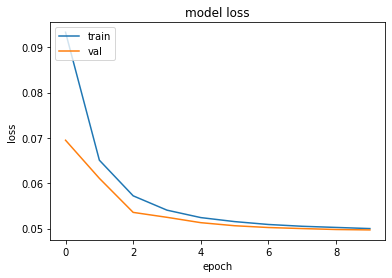

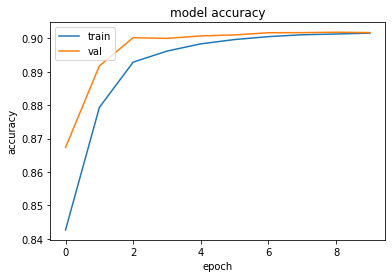

5/5 [==============================] - 1s 93ms/step - loss: 0.0498
test loss, test acc: 0.04980406165122986


In [16]:
if __name__ == '__main__':
    trained_model,X_test,y_test = train_model()
    testing_model(trained_model,X_test,y_test)

